In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [2]:
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, IterableDataset
from tqdm import tqdm

In [3]:
os.chdir('..')
# os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [4]:
from fashion_recommendations.metrics.average_precision import mapk

In [5]:
pd.options.display.max_columns = None

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Load transactions

In [7]:
# ' '.join(transactions_train['article_id'].value_counts().head(12).index.tolist())

In [8]:
transactions_train = pd.read_csv('data/transactions_train.csv', dtype={'article_id': str})
print(transactions_train.shape)
transactions_train.head()

(31788324, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2


In [9]:
transactions_train['t_dat'] = pd.to_datetime(transactions_train['t_dat'])

In [10]:
transactions_train.groupby('customer_id')['article_id'].count().describe()

count    1.362281e+06
mean     2.333463e+01
std      3.924225e+01
min      1.000000e+00
25%      3.000000e+00
50%      9.000000e+00
75%      2.700000e+01
max      1.895000e+03
Name: article_id, dtype: float64

### Load articles

In [11]:
articles_df = pd.read_csv(
    'data/articles.csv', 
    dtype={'article_id': str},
    usecols=['article_id', 'garment_group_name', 'detail_desc']
)
print(articles_df.shape)
articles_df.head()

(105542, 3)


,article_id,garment_group_name,detail_desc
0,0108775015,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [12]:
articles_df.isnull().sum()

article_id              0
garment_group_name      0
detail_desc           416
dtype: int64

In [13]:
articles_df['detail_desc'] = np.where(
    articles_df['detail_desc'].isnull(), 
    articles_df['garment_group_name'], 
    articles_df['detail_desc']
)

### Find cut-offs

In [14]:
end = transactions_train['t_dat'].max()
endm1 = end - datetime.timedelta(days=7)
endm2 = endm1 - datetime.timedelta(days=7)
endm3 = endm2 - datetime.timedelta(days=7)

In [15]:
end, endm1, endm2, endm3

(Timestamp('2020-09-22 00:00:00'),
 Timestamp('2020-09-15 00:00:00'),
 Timestamp('2020-09-08 00:00:00'),
 Timestamp('2020-09-01 00:00:00'))

train
- inputs: start - endm3
- labels: emdm3 - endm2

dev
- inputs: start - endm2
- labels: emdm2 - endm1

test 
- inputs: start - endm1
- labels: endm1 - end

In [16]:
transactions_train = transactions_train.copy()[transactions_train['t_dat'] > '2020-05-01']

In [17]:
transactions_train['customer_id'].nunique()

665025

In [18]:
# % of items in last week which didn't appear in prior weeks' transactions
len(set(transactions_train[transactions_train['t_dat'] > endm1]['article_id']) - set(transactions_train[transactions_train['t_dat'] <= endm1]['article_id'])) / transactions_train[transactions_train['t_dat'] > endm1]['article_id'].nunique()

0.045813410430334704

In [19]:
transactions_train.shape

(6481103, 5)

In [20]:
transactions_train['article_id'].nunique() / articles_df.shape[0]

0.46167402550643344

### Filter out unnecessary articles

In [21]:
articles_df = articles_df.copy()[
    articles_df['article_id'].isin(transactions_train['article_id'].unique())
]

articles_df.reset_index(drop=True, inplace=True)
articles_df.drop(columns=['garment_group_name'], inplace=True)
print(articles_df.shape)
articles_df.head()

(48726, 2)


,article_id,detail_desc
0,0108775015,Jersey top with narrow shoulder straps.
1,0108775044,Jersey top with narrow shoulder straps.
2,0110065001,"Microfibre T-shirt bra with underwired, moulde..."
3,0110065002,"Microfibre T-shirt bra with underwired, moulde..."
4,0110065011,"Microfibre T-shirt bra with underwired, moulde..."


In [22]:
articles_df['article_id_idx'] = articles_df.index

In [23]:
article_id_to_idx = dict(zip(articles_df['article_id'], articles_df['article_id_idx']))

In [24]:
transactions_train['article_id_idx'] = transactions_train['article_id'].map(article_id_to_idx)
transactions_train['article_id_idx'] = transactions_train['article_id_idx'].astype(str)

### Create splits

#### Illustrative steps:

In [ ]:
dev_labels = transactions_train.copy()[transactions_train['t_dat'] > endm1]

In [ ]:
dev_inputs = transactions_train.copy()[transactions_train['t_dat'] <= endm1]

In [ ]:
print(dev_inputs.shape)
dev_inputs.head()

In [ ]:
dev_inputs.sort_values(['customer_id', 't_dat'], inplace=True)
dev_inputs.head()

In [ ]:
# dev_inputs['total_purchases'] = dev_inputs.groupby('customer_id')['article_id'].transform('count')

In [ ]:
# print(dev_inputs.shape)
# dev_inputs = dev_inputs.copy()[dev_inputs['total_purchases'] >= 10]
# print(dev_inputs.shape)

In [ ]:
dev_inputs['article_id_idx'] = dev_inputs['article_id_idx'].astype(str)

- Age of last transaction
- Transaction count
- Incoporate count in vector representation

In [ ]:
latest_transaction_date_by_cust = dev_inputs.groupby('customer_id')[['customer_id', 't_dat']].tail(1)
latest_transaction_date_by_cust.head()

In [ ]:
dev_inputs = (
    dev_inputs
        .groupby('customer_id')
        .tail(10)  # Most recent articles only
        .groupby('customer_id')['article_id_idx']
        .apply(lambda x: ','.join(x))
        .reset_index()
)
print(dev_inputs.shape)
dev_inputs.head()

In [ ]:
dev_inputs = dev_inputs.merge(latest_transaction_date_by_cust.rename(columns={'t_dat': 't_dat_latest'}), on='customer_id')
print(dev_inputs.shape)
dev_inputs.head()

In [ ]:
dev_labels.shape

In [ ]:
dev_labels.head()

In [ ]:
num_purchases_df = dev_labels.groupby(['customer_id', 'article_id'])['t_dat'].count().reset_index().rename(columns={'t_dat': 'num_purchases'})
print(num_purchases_df.shape)
num_purchases_df.head()

In [ ]:
num_purchases_df['num_purchases'] = num_purchases_df['num_purchases'].astype(str)

In [ ]:
dev_labels = num_purchases_df.groupby('customer_id').agg(
    {
        'article_id': lambda x: ','.join(x),
        'num_purchases': lambda x: ','.join(x)
    }
).reset_index()

print(dev_labels.shape)
dev_labels.head()

In [ ]:
dev_set = dev_inputs.merge(dev_labels, on='customer_id', how='outer', indicator=True, suffixes=('_last10', '_label'))
dev_set.shape

In [ ]:
dev_set['_merge'].value_counts() / dev_set.shape[0]

`left_only` = customers who did not make purchases in last week

`both` = customers who did make purchases in last week and made purchases in the past

`right_only` = customers who did make purchases in last week but made no purchases in the past (cold start)

Keep `both` only. For cold start we can just predict top-12 and `left_only` won't contribute to MAP

In [ ]:
dev_set = dev_set.copy()[dev_set['_merge'] == 'both']
dev_set.drop('_merge', inplace=True, axis=1)
print(dev_set.shape)
dev_set.head()

In [ ]:
endm3

In [ ]:
endm3 - datetime.timedelta(days=100)

In [ ]:
dev_set['example_age'] = (endm3 - dev_set['t_dat_latest']).dt.days / 100

In [ ]:
dev_set['example_age'].hist()

In [ ]:
dev_set.head()

#### Function

train
- inputs: start - endm3
- labels: emdm3 - endm2

dev
- inputs: start - endm2
- labels: emdm2 - endm1

test 
- inputs: start - endm1
- labels: endm1 - end

In [25]:
MAX_PURCHASE_HISTORY = 100

def create_article_input_output_df(inputs, labels, example_age_end, max_purchase_history=MAX_PURCHASE_HISTORY):
    
    inputs = inputs.copy()
    labels = labels.copy()
    
    inputs.sort_values(['customer_id', 't_dat'], inplace=True)

    inputs['article_id_idx'] = inputs['article_id_idx'].astype(str)
    
    latest_transaction_date_by_cust = (
        inputs
            .groupby('customer_id')[['customer_id', 't_dat']]
            .tail(1)
    )
    
    inputs = (
        inputs
            .groupby('customer_id')
            .tail(max_purchase_history)  # Most recent articles only
            .groupby('customer_id')['article_id_idx']
            .apply(lambda x: ','.join(x))
            .reset_index()
    )
    
    inputs = inputs.merge(
        latest_transaction_date_by_cust.rename(columns={'t_dat': 't_dat_latest'}), 
        on='customer_id'
    )
    
    num_purchases_df = (
        labels
            .groupby(['customer_id', 'article_id_idx'])['t_dat']
            .count()
            .reset_index()
            .rename(columns={'t_dat': 'num_purchases'})
    )
    
    num_purchases_df['num_purchases'] = num_purchases_df['num_purchases'].astype(str)
    
    labels = num_purchases_df.groupby('customer_id').agg(
        {
            'article_id_idx': lambda x: ','.join(x),
            'num_purchases': lambda x: ','.join(x)
        }
    ).reset_index()

    data_set = inputs.merge(labels, on='customer_id', how='outer', indicator=True, suffixes=('_last10', '_label'))

    data_set = data_set.copy()[data_set['_merge'] == 'both']
    data_set.drop('_merge', inplace=True, axis=1)
    
    data_set['example_age'] = (example_age_end - data_set['t_dat_latest']).dt.days / 100

    return data_set

In [26]:
train_set = create_article_input_output_df(
    inputs=transactions_train.copy()[transactions_train['t_dat'] <= endm3], 
    labels=transactions_train.copy()[
        (transactions_train['t_dat'] > endm3) &
        (transactions_train['t_dat'] < endm2)
    ],
    example_age_end=endm3
)

print(train_set.shape)
train_set.head()

(52787, 6)


,customer_id,article_id_idx_last10,t_dat_latest,article_id_idx_label,num_purchases,example_age
16,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,21238,2020-07-21,10445,3,0.42
19,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,"41719,42729,41846,29230,35992,42707,39135,2846...",2020-09-01,"4133,43785,46699,47830,48528","1,1,1,1,1",0.00
20,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,"37073,33658,28336,27815,30331",2020-08-07,30871,1,0.25
36,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,"16160,41543,24022,41131,41131,48130,47628,44359",2020-08-11,"46077,46294,47057","1,1,1",0.21
51,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,"16166,34109,37155,39059,42550,31027,32928,1399...",2020-07-12,"14131,20444,20448,27775,31005,45912,45914,46007","1,1,1,1,1,1,1,1",0.51


In [27]:
train_set['example_age'].min(), train_set['example_age'].max()

(0.0, 1.22)

In [28]:
dev_set = create_article_input_output_df(
    inputs=transactions_train.copy()[transactions_train['t_dat'] <= endm2], 
    labels=transactions_train.copy()[
        (transactions_train['t_dat'] > endm2) &
        (transactions_train['t_dat'] < endm1)
    ],
    example_age_end=endm3
)

print(dev_set.shape)
dev_set.head()

(52343, 6)


,customer_id,article_id_idx_last10,t_dat_latest,article_id_idx_label,num_purchases,example_age
20,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,"42707,39135,28464,22243,37083,23103,30023,4636...",2020-09-07,16299,1,-0.06
38,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,"16160,41543,24022,41131,41131,48130,47628,4435...",2020-09-05,"42436,43977,6392,7586","2,1,1,1",-0.04
45,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,"12905,12904,30886,12378,634,32778,43477,40051,...",2020-07-03,"16017,16018,16019,30046,3173,36210,4279,807","1,1,1,1,1,1,1,1",0.60
78,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,"46942,45237,27765,30317,44011,31540,27764,2776...",2020-07-25,"1234,39226,48295,48451","1,1,1,1",0.38
86,0008968c0d451dbc5a9968da03196fe20051965edde741...,"30344,37175,30345,36229,29216,32463,29216,3597...",2020-08-27,44654,1,0.05


In [29]:
dev_set['example_age'].min(), dev_set['example_age'].max()

(-0.07, 1.22)

In [30]:
test_set = create_article_input_output_df(
    inputs=transactions_train.copy()[transactions_train['t_dat'] <= endm1], 
    labels=transactions_train.copy()[
        (transactions_train['t_dat'] > endm1)
    ],
    example_age_end=endm3
)

print(test_set.shape)
test_set.head()

(54947, 6)


,customer_id,article_id_idx_last10,t_dat_latest,article_id_idx_label,num_purchases,example_age
40,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,"16160,41543,24022,41131,41131,48130,47628,4435...",2020-09-14,32216,1,-0.13
48,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,"12905,12904,30886,12378,634,32778,43477,40051,...",2020-09-09,"20199,24660,7590","1,1,1",-0.08
82,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,"46942,45237,27765,30317,44011,31540,27764,2776...",2020-09-12,"1102,1558,26347,39765,42252,44,46006,46423,472...","1,1,1,1,1,1,1,1,1,1,1,1,1,1",-0.11
157,000fb6e772c5d0023892065e659963da90b1866035558e...,"16678,34489,4108,38950,39021,4114,5739,35808,3...",2020-09-10,"24330,40688,44078,47049,47575","1,3,2,2,1",-0.09
165,0010e8eb18f131e724d6997909af0808adbba057529edb...,"34886,34888,10681,205,34888,23249,34470,34412,...",2020-08-25,"1234,207,3494,45186,45690,47136,5740,5762,629","1,1,1,1,1,1,1,1,1",0.07


In [31]:
test_set['example_age'].min(), test_set['example_age'].max()

(-0.14, 1.22)

Inputs for submission:

In [32]:
submission_inputs = transactions_train.copy()

submission_inputs.sort_values(['customer_id', 't_dat'], inplace=True)

submission_inputs['article_id_idx'] = submission_inputs['article_id_idx'].astype(str)

latest_transaction_date_by_cust = (
    submission_inputs
        .groupby('customer_id')[['customer_id', 't_dat']]
        .tail(1)
)

submission_inputs = (
    submission_inputs
        .groupby('customer_id')
        .tail(MAX_PURCHASE_HISTORY)  # Most recent articles only
        .groupby('customer_id')['article_id_idx']
        .apply(lambda x: ','.join(x))
        .reset_index()
)

submission_inputs = submission_inputs.merge(
    latest_transaction_date_by_cust.rename(columns={'t_dat': 't_dat_latest'}), 
    on='customer_id'
)

submission_inputs['example_age'] = (endm3 - submission_inputs['t_dat_latest']).dt.days / 100

In [33]:
submission_inputs.head()

,customer_id,article_id_idx,t_dat_latest,example_age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,3862,2020-09-05,-0.04
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,32040,2020-07-08,0.55
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,25450,2020-09-15,-0.14
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"4764,32303,30487,45052,15749,48137,25087",2020-08-12,0.20
4,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,"14660,1102",2020-09-14,-0.13


In [34]:
submission_inputs.rename(columns={'article_id_idx': 'article_id_idx_last10'}, inplace=True)
submission_inputs['article_id_idx_label'] = '0'
print(submission_inputs.shape)
submission_inputs.head()

(665025, 5)


,customer_id,article_id_idx_last10,t_dat_latest,example_age,article_id_idx_label
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,3862,2020-09-05,-0.04,0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,32040,2020-07-08,0.55,0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,25450,2020-09-15,-0.14,0
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"4764,32303,30487,45052,15749,48137,25087",2020-08-12,0.20,0
4,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,"14660,1102",2020-09-14,-0.13,0


In a given week what proportion of total customers make a purchase?

In [35]:
submission_inputs['num_purchases'] = '1'

In [36]:
all_customers = pd.read_csv('data/sample_submission.csv').shape[0]

In [37]:
submission_inputs.shape[0]

665025

In [38]:
print(dev_set['customer_id'].shape[0] / all_customers)
print(test_set['customer_id'].shape[0] / all_customers)

0.038151430778874326
0.04004941762999461


In [39]:
print(dev_set['customer_id'].shape[0] / submission_inputs.shape[0])
print(test_set['customer_id'].shape[0] / submission_inputs.shape[0])

0.07870831923611894
0.08262396150520657


Proportion of customers in dev/test sets who appear in training

In [40]:
dev_set[dev_set['customer_id'].isin(train_set['customer_id'])].shape[0] / dev_set.shape[0]

0.1954607110788453

In [41]:
test_set[test_set['customer_id'].isin(train_set['customer_id'])].shape[0] / dev_set.shape[0]

0.18594654490571805

Filter out customers who don't appear in training

In [42]:
dev_set = dev_set.copy()[dev_set['customer_id'].isin(train_set['customer_id'])]
test_set = test_set.copy()[test_set['customer_id'].isin(train_set['customer_id'])]

In [43]:
train_set.shape

(52787, 6)

In [44]:
dev_set.shape

(10231, 6)

In [45]:
test_set.shape

(9733, 6)

<AxesSubplot:>

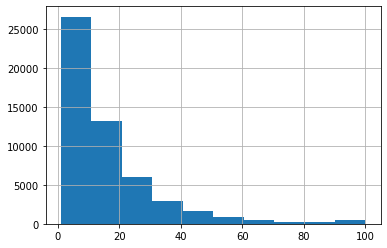

In [46]:
train_set['article_id_idx_last10'].str.split(',').apply(len).hist()

<AxesSubplot:>

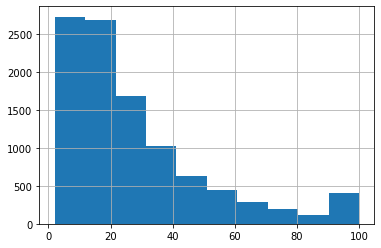

In [47]:
dev_set['article_id_idx_last10'].str.split(',').apply(len).hist()

<AxesSubplot:>

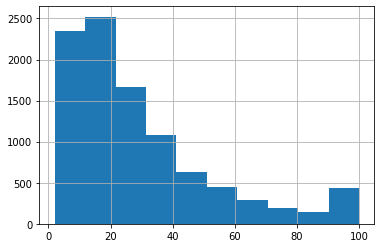

In [48]:
test_set['article_id_idx_last10'].str.split(',').apply(len).hist()

### Filter customers and get customer features

In [49]:
customers = pd.read_csv('data/customers.csv')

In [50]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [51]:
customers.isnull().sum() / customers.shape[0]

customer_id               0.000000
FN                        0.652378
Active                    0.661508
club_member_status        0.004418
fashion_news_frequency    0.011669
age                       0.011561
postal_code               0.000000
dtype: float64

In [52]:
customers['club_member_status'].unique()

array(['ACTIVE', nan, 'PRE-CREATE', 'LEFT CLUB'], dtype=object)

In [53]:
customers['fashion_news_frequency'].unique()

array(['NONE', 'Regularly', nan, 'Monthly', 'None'], dtype=object)

In [54]:
customers['postal_code'].nunique()

352899

In [55]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace({'NONE': np.nan, 'None': np.nan})

In [56]:
customers['fashion_news_frequency'].isnull().sum() / customers.shape[0]

0.6514103704135629

In [57]:
customers['fashion_news_frequency'].fillna('MISSING', inplace=True)

In [58]:
customers['club_member_status'].fillna('MISSING', inplace=True)

In [59]:
customers['club_member_status'].unique()

array(['ACTIVE', 'MISSING', 'PRE-CREATE', 'LEFT CLUB'], dtype=object)

In [60]:
customers['fashion_news_frequency'].unique()

array(['MISSING', 'Regularly', 'Monthly'], dtype=object)

In [61]:
club_member_status_to_idx = {
    'ACTIVE': 0, 
    'MISSING': 1, 
    'PRE-CREATE': 2, 
    'LEFT CLUB': 3
}

In [62]:
fashion_news_frequency_to_idx = {
    'MISSING': 0, 
    'Regularly': 1, 
    'Monthly': 2
}

In [63]:
customers = pd.read_csv('data/customers.csv', usecols=['customer_id', 'FN', 'Active', 'age', 'club_member_status', 'fashion_news_frequency', 'postal_code'])
print(customers.shape)
customers.head()

(1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [64]:
customers_to_keep = set(train_set['customer_id'])
len(customers_to_keep)

52787

Filter out other customers from submission inputs (for other customers we'll just predict top-12)

In [65]:
len(customers_to_keep) / len(submission_inputs)

0.07937596330965001

In [66]:
submission_inputs = submission_inputs.copy()[submission_inputs['customer_id'].isin(customers_to_keep)]
submission_inputs.shape

(52787, 6)

In [67]:
customers = customers.copy()[customers['customer_id'].isin(customers_to_keep)]
customers.reset_index(drop=True, inplace=True)
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,NaN,NaN,ACTIVE,NONE,45.0,4ca377c955c160866d5662b33aa1af44d54d4342fb8bfa...
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,1.0,1.0,ACTIVE,Regularly,44.0,930b19ae7db8abb5a27f4da10217755a7305b4c452f5e0...
2,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,NaN,NaN,ACTIVE,NONE,21.0,4211d6bf468de190b2f135feed96ed94b1c47f1d68991c...
3,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,1.0,1.0,ACTIVE,Regularly,33.0,d647e4ede3d0eb4ce0750440a110350b5f4c758165d89d...
4,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,NaN,NaN,ACTIVE,NONE,21.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...


In [68]:
customers.isnull().sum() / customers.shape[0]

customer_id               0.000000
FN                        0.522667
Active                    0.529543
club_member_status        0.001402
fashion_news_frequency    0.001970
age                       0.003486
postal_code               0.000000
dtype: float64

In [69]:
customers[['FN', 'Active']] = customers[['FN', 'Active']].fillna(0)

Despite potential data leakage we impute the nulls for age here:

In [70]:
customers.shape

(52787, 7)

In [71]:
from sklearn.impute import SimpleImputer

In [72]:
simple_imputer = SimpleImputer()

In [73]:
customers[['age']] = simple_imputer.fit_transform(customers[['age']])

In [74]:
customers['age'] /= 100

In [75]:
customers.isnull().sum() / customers.shape[0]

customer_id               0.000000
FN                        0.000000
Active                    0.000000
club_member_status        0.001402
fashion_news_frequency    0.001970
age                       0.000000
postal_code               0.000000
dtype: float64

In [76]:
customers['customer_id_idx'] = customers.index

Map `club_member_status` and `fashion_frequency` to IDs

In [77]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace({'NONE': np.nan, 'None': np.nan})

In [78]:
customers['fashion_news_frequency'].isnull().sum() / customers.shape[0]

0.5215109780817246

In [79]:
customers['fashion_news_frequency'].fillna('MISSING', inplace=True)

In [80]:
customers['club_member_status'].fillna('MISSING', inplace=True)

In [81]:
customers['fashion_news_frequency_idx'] = customers['fashion_news_frequency'].map(fashion_news_frequency_to_idx)

In [82]:
customers['club_member_status_idx'] = customers['club_member_status'].map(club_member_status_to_idx)

In [83]:
customers.isnull().sum() / customers.shape[0]

customer_id                   0.0
FN                            0.0
Active                        0.0
club_member_status            0.0
fashion_news_frequency        0.0
age                           0.0
postal_code                   0.0
customer_id_idx               0.0
fashion_news_frequency_idx    0.0
club_member_status_idx        0.0
dtype: float64

Postal code

In [84]:
customers['postal_code'].nunique()

46025

In [85]:
customers['postal_code'].value_counts()

2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c    721
7c1fa3b0ec1d37ce2c3f34f63bd792f3b4494f324b6be5d1e4ba6a75456b96a7     13
1f5bd429acc88fbbf24de844a59e438704aa8761bc7b99fd977cad297c50b74c     10
9d5787501bf1c77592156ba51eab13f4a2670c807686431a9e22a69090b02358     10
1cffd42ab4bd892f8688dff5b7e76946fc799bc8c18804e458a8d64f03407819      9
                                                                   ... 
510b1a4ce6a8fda144f40365b40b32664b4f77226e1db6875b757b395619f733      1
8c105e620884d7cdf7d15d3848964a555031de85cff21d840e03ee947efdfbf8      1
77c601cd1891b8eba9bd58603416be6e4a299602f535d5270a85a67073aaaf15      1
86445e750e32cb9658c6f2d11fcf716f638cc90fa00f6d92bee2b13f22b22b90      1
7aa399f7e669990daba2d92c577b52237380662f36480ba9c302f5ec7028f8e6      1
Name: postal_code, Length: 46025, dtype: int64

In [86]:
postal_code_df = customers[['postal_code']].drop_duplicates()
postal_code_df.reset_index(drop=True, inplace=True)
print(postal_code_df.shape)
postal_code_df.head()

(46025, 1)


,postal_code
0,4ca377c955c160866d5662b33aa1af44d54d4342fb8bfa...
1,930b19ae7db8abb5a27f4da10217755a7305b4c452f5e0...
2,4211d6bf468de190b2f135feed96ed94b1c47f1d68991c...
3,d647e4ede3d0eb4ce0750440a110350b5f4c758165d89d...
4,2c29ae653a9282cce4151bd87643c907644e09541abc28...


In [87]:
postal_code_to_idx = dict(zip(postal_code_df['postal_code'], postal_code_df.index.tolist()))

In [88]:
customers['postal_code_idx'] = customers['postal_code'].map(postal_code_to_idx)

In [89]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,customer_id_idx,fashion_news_frequency_idx,club_member_status_idx,postal_code_idx
0,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,0.0,0.0,ACTIVE,MISSING,0.45,4ca377c955c160866d5662b33aa1af44d54d4342fb8bfa...,0,0,0,0
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,1.0,1.0,ACTIVE,Regularly,0.44,930b19ae7db8abb5a27f4da10217755a7305b4c452f5e0...,1,1,0,1
2,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,0.0,0.0,ACTIVE,MISSING,0.21,4211d6bf468de190b2f135feed96ed94b1c47f1d68991c...,2,0,0,2
3,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,1.0,1.0,ACTIVE,Regularly,0.33,d647e4ede3d0eb4ce0750440a110350b5f4c758165d89d...,3,1,0,3
4,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,0.0,0.0,ACTIVE,MISSING,0.21,2c29ae653a9282cce4151bd87643c907644e09541abc28...,4,0,0,4


In [90]:
train_set = train_set.merge(customers, on=['customer_id'])
dev_set = dev_set.merge(customers, on=['customer_id'])
test_set = test_set.merge(customers, on=['customer_id'])

In [91]:
submission_inputs = submission_inputs.merge(customers, on=['customer_id'])

In [92]:
train_set.head()

,customer_id,article_id_idx_last10,t_dat_latest,article_id_idx_label,num_purchases,example_age,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,customer_id_idx,fashion_news_frequency_idx,club_member_status_idx,postal_code_idx
0,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,21238,2020-07-21,10445,3,0.42,0.0,0.0,ACTIVE,MISSING,0.45,4ca377c955c160866d5662b33aa1af44d54d4342fb8bfa...,0,0,0,0
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,"41719,42729,41846,29230,35992,42707,39135,2846...",2020-09-01,"4133,43785,46699,47830,48528","1,1,1,1,1",0.00,1.0,1.0,ACTIVE,Regularly,0.44,930b19ae7db8abb5a27f4da10217755a7305b4c452f5e0...,1,1,0,1
2,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,"37073,33658,28336,27815,30331",2020-08-07,30871,1,0.25,0.0,0.0,ACTIVE,MISSING,0.21,4211d6bf468de190b2f135feed96ed94b1c47f1d68991c...,2,0,0,2
3,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,"16160,41543,24022,41131,41131,48130,47628,44359",2020-08-11,"46077,46294,47057","1,1,1",0.21,1.0,1.0,ACTIVE,Regularly,0.33,d647e4ede3d0eb4ce0750440a110350b5f4c758165d89d...,3,1,0,3
4,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,"16166,34109,37155,39059,42550,31027,32928,1399...",2020-07-12,"14131,20444,20448,27775,31005,45912,45914,46007","1,1,1,1,1,1,1,1",0.51,0.0,0.0,ACTIVE,MISSING,0.21,2c29ae653a9282cce4151bd87643c907644e09541abc28...,4,0,0,4


In [93]:
train_set = train_set[['customer_id_idx', 'article_id_idx_last10', 'article_id_idx_label', 'FN', 'Active', 'age', 'num_purchases', 'example_age', 'fashion_news_frequency_idx', 'club_member_status_idx', 'postal_code_idx']]
dev_set = dev_set[['customer_id_idx', 'article_id_idx_last10', 'article_id_idx_label', 'FN', 'Active', 'age', 'num_purchases', 'example_age', 'fashion_news_frequency_idx', 'club_member_status_idx', 'postal_code_idx']]
test_set = test_set[['customer_id_idx', 'article_id_idx_last10', 'article_id_idx_label', 'FN', 'Active', 'age', 'num_purchases', 'example_age', 'fashion_news_frequency_idx', 'club_member_status_idx', 'postal_code_idx']]

In [94]:
submission_inputs = submission_inputs[['customer_id_idx', 'article_id_idx_last10', 'article_id_idx_label', 'FN', 'Active', 'age', 'num_purchases', 'example_age', 'fashion_news_frequency_idx', 'club_member_status_idx', 'postal_code_idx']]

In [95]:
train_set.head()

,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age,num_purchases,example_age,fashion_news_frequency_idx,club_member_status_idx,postal_code_idx
0,0,21238,10445,0.0,0.0,0.45,3,0.42,0,0,0
1,1,"41719,42729,41846,29230,35992,42707,39135,2846...","4133,43785,46699,47830,48528",1.0,1.0,0.44,"1,1,1,1,1",0.00,1,0,1
2,2,"37073,33658,28336,27815,30331",30871,0.0,0.0,0.21,1,0.25,0,0,2
3,3,"16160,41543,24022,41131,41131,48130,47628,44359","46077,46294,47057",1.0,1.0,0.33,"1,1,1",0.21,1,0,3
4,4,"16166,34109,37155,39059,42550,31027,32928,1399...","14131,20444,20448,27775,31005,45912,45914,46007",0.0,0.0,0.21,"1,1,1,1,1,1,1,1",0.51,0,0,4


In [96]:
dev_set.head()

,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age,num_purchases,example_age,fashion_news_frequency_idx,club_member_status_idx,postal_code_idx
0,1,"42707,39135,28464,22243,37083,23103,30023,4636...",16299,1.0,1.0,0.44,1,-0.06,1,0,1
1,3,"16160,41543,24022,41131,41131,48130,47628,4435...","42436,43977,6392,7586",1.0,1.0,0.33,"2,1,1,1",-0.04,1,0,3
2,13,"1374,38644,14448,28729,34842,33575,33575,33575...","18461,20230,20812,26646,26652,42288",0.0,0.0,0.41,"1,1,1,1,1,2",-0.03,0,0,12
3,15,"16678,34489,4108,38950,39021,4114,5739,35808,3...","20931,43183,47575,48163",1.0,1.0,0.42,"1,1,2,2",-0.05,1,0,14
4,17,"5045,12328,240,6132,3659,21195,36713,20502,289...","44663,46496",1.0,1.0,0.23,"1,1",-0.07,1,0,16


In [97]:
submission_inputs.head()

,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age,num_purchases,example_age,fashion_news_frequency_idx,club_member_status_idx,postal_code_idx
0,0,"21238,10445,10445,10445",0,0.0,0.0,0.45,1,-0.03,0,0,0
1,1,"39135,28464,22243,37083,23103,30023,46364,3375...",0,1.0,1.0,0.44,1,-0.13,1,0,1
2,2,"37073,33658,28336,27815,30331,30871",0,0.0,0.0,0.21,1,-0.01,0,0,2
3,3,"16160,41543,24022,41131,41131,48130,47628,4435...",0,1.0,1.0,0.33,1,-0.21,1,0,3
4,4,"16166,34109,37155,39059,42550,31027,32928,1399...",0,0.0,0.0,0.21,1,-0.02,0,0,4


### Save files

In [98]:
train_set.to_csv('data/final_train_set_with_counts_and_age_extended_100_hist_with_more_cust_feat.tsv', sep='\t', index=False)
dev_set.to_csv('data/final_dev_set_with_counts_and_age_extended_100_hist_with_more_cust_feat.tsv', sep='\t', index=False)
test_set.to_csv('data/final_test_set_with_counts_and_age_extended_100_hist_with_more_cust_feat.tsv', sep='\t', index=False)
submission_inputs.to_csv('data/final_submission_inputs_with_counts_and_age_extended_100_hist_with_more_cust_feat.tsv', sep='\t', index=False)

articles_df.to_csv('data/articles_df_filt_with_counts_and_age_extended_100_hist_with_more_cust_feat.csv', index=False)
customers.to_csv('data/customers_filt_with_counts_and_age_extended_100_hist_with_more_cust_feat.csv', index=False)

### IterableDataset

In [70]:
class RecommendationDatasetMultiLabel(IterableDataset):

    def __init__(self, dataset_filepath, article_emb_bag, total_articles):
        
        self.dataset_itr = open(dataset_filepath, 'r')
        next(self.dataset_itr)  # skip header
        
        self.article_emb_bag = article_emb_bag
        
        self.total_articles = total_articles
    
    def process_label(self, label_str: str, num_purchases_str: str):
        
        labels = torch.tensor([int(v) for v in label_str.split(',')])
        
        num_purchases = torch.tensor([float(v) for v in num_purchases_str.split(',')])
        
        target = torch.zeros(self.total_articles).scatter_(0, labels, num_purchases)

        return target
    
    def mean_historical_purchases_embedding(self, input_str: str):
        
        indices = torch.tensor([int(v) for v in input_str.split(',')])

        mean_emb = self.article_emb_bag(indices.unsqueeze(0)).flatten()
            
        return mean_emb
    
    def process_numeric_features(self, fn: str, active: str, age: str, example_age: str):
        numeric_features_tensor = torch.tensor([
            float(fn),
            float(active),
            float(age),
            float(example_age)
        ])

        return numeric_features_tensor
    
    def parse_itr(self, dataset_itr):
        
        for line in dataset_itr:
        
            line_items = line.rstrip('\n').split('\t')
            
            customer_id_idx, article_id_idx_last10, article_id_idx_label, fn, active, age, num_purchases, example_age = line_items
            
            customer_id_idx = int(customer_id_idx)
            
            numeric_features_tensor = self.process_numeric_features(fn, active, age, example_age)
            
            mean_emb = self.mean_historical_purchases_embedding(article_id_idx_last10)

            label = self.process_label(article_id_idx_label, num_purchases)    
            
            inputs = torch.concat((mean_emb, numeric_features_tensor))

            yield customer_id_idx, inputs, label
        
    def get_stream(self, dataset_itr):
        
        return self.parse_itr(dataset_itr)

    def __iter__(self):
        
        return self.get_stream(self.dataset_itr)

In [81]:
dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set_with_counts_and_age.tsv', article_emb_bag=article_emb_bag, total_articles=total_articles)

In [84]:
pd.read_csv('data/final_train_set_with_counts_and_age.tsv', sep='\t').head(20)

,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age,num_purchases,example_age
0,0,15861,7705,0.0,0.0,0.45,3,0.42
1,1,"38882,3152,31459,3157,39673,39510,17255,26222,...","3160,35654,38515,39642,40340",1.0,1.0,0.44,"1,1,1,1,1",0.00
2,2,"21627,21175,23351",23816,0.0,0.0,0.21,1,0.25
3,3,"18099,33097,33097,39942,39441,36213","37897,38110,38872",1.0,1.0,0.33,"1,1,1",0.21
4,4,"23950,25602,10293,29865,19920,34107,25721,2152...","10396,15220,15224,21141,23930,37733,37735,37827",0.0,0.0,0.21,"1,1,1,1,1,1,1,1",0.51
5,5,"23368,29644,546,7957","23326,34657,34797,37783",0.0,0.0,0.19,"2,1,1,1",0.32
6,6,"32407,33337,34491,34150,39072,14076,14074,2120...","39072,40138",0.0,0.0,0.36,"1,1",0.02
7,7,"4388,37067,32054,30795,33397,15496,26253,1059,...","24455,30121",0.0,0.0,0.40,"1,1",0.19
8,8,"21970,10865","2471,35881,37827",1.0,1.0,0.22,"1,1,1",0.50
9,9,"25681,24592,30530,2370","23806,30609,37567",1.0,1.0,0.59,"1,1,1",0.35


In [83]:
train_loader = DataLoader(dataset, batch_size=4)  
    
for idx, data in enumerate(train_loader):
    
    if idx == 5:
        break
    else:
        customer_id_idx, inputs, label = data
        print(customer_id_idx)
        print(inputs)
        print(label)
        print(label.max(dim=1))
        print('\n')

tensor([0, 1, 2, 3])
tensor([[-1.2173,  0.1219, -0.2311,  ...,  0.0000,  0.4500,  0.4200],
        [-0.1295, -0.0226,  0.2097,  ...,  1.0000,  0.4400,  0.0000],
        [ 0.0787, -0.0579,  0.0796,  ...,  0.0000,  0.2100,  0.2500],
        [ 0.2321,  0.9143, -1.3484,  ...,  1.0000,  0.3300,  0.2100]],
       grad_fn=<StackBackward0>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.return_types.max(
values=tensor([3., 1., 1., 1.]),
indices=tensor([ 7705,  3160, 23816, 37897]))


tensor([4, 5, 6, 7])
tensor([[ 0.4209,  0.1502,  0.3306,  ...,  0.0000,  0.2100,  0.5100],
        [ 0.3754, -0.4886, -0.1319,  ...,  0.0000,  0.1900,  0.3200],
        [-0.6902,  0.3733, -0.0310,  ...,  0.0000,  0.3600,  0.0200],
        [-0.5472,  0.3336,  0.1550,  ...,  0.0000,  0.4000,  0.1900]],
       grad_fn=<StackBackward0>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..

torch.return_types.max(
values=tensor([1., 1., 1., 1.]),
indices=tensor([ 1355, 23407, 37585, 18835]))

### TODO

- Wrap processing steps in a function and apply to train, test sets  [DONE]
- Add customer features here (FN, Active, Age)  [DONE]
- Save sets as CSVs  [DONE]
- Save reduced articles df - use to generate correct embeddings by index  [DONE]
- Save customers df - use to generate correct embeddings by index  [DONE]
- Write iterable dataset which processes dataset  [DONE]
    - Get mean for each of inputs and take average to use as input
    - Multi-hot encode label

Checks of proecessing steps:

Multi-hot encoding:

https://discuss.pytorch.org/t/what-kind-of-loss-is-better-to-use-in-multilabel-classification/32203/3

In [101]:
article_id_idx_label = dev_set.iloc[3]['article_id_idx_label']
article_id_idx_label

'18345,38864,35941,32663,39388'

In [72]:
total_articles = articles_df.shape[0]

In [112]:
labels = torch.tensor([int(v) for v in article_id_idx_label.split(',')])
labels

tensor([18345, 38864, 35941, 32663, 39388])

In [111]:
target = torch.zeros(total_articles).scatter_(0, labels, 1.)
target

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [114]:
target[labels]

tensor([1., 1., 1., 1., 1.])

In [115]:
target.sum()

tensor(5.)

Getting mean encoding of historical basket

In [73]:
article_emb_bag = nn.EmbeddingBag(num_embeddings=total_articles, embedding_dim=384)

In [135]:
article_id_idx_last10 = dev_set.iloc[5]['article_id_idx_last10']
article_id_idx_last10

'37757,34393,5646,38997'

In [136]:
indices = torch.tensor([int(v) for v in article_id_idx_last10.split(',')])
indices

tensor([37757, 34393,  5646, 38997])

In [137]:
indices.unsqueeze(0)

tensor([[37757, 34393,  5646, 38997]])

In [138]:
mean_emb = article_emb_bag(indices.unsqueeze(0))
mean_emb.shape

torch.Size([1, 384])

In [139]:
torch.testing.assert_allclose(
    mean_emb.flatten(),
    article_emb_bag.weight[indices].mean(dim=0)
)

In [141]:
mean_emb = article_emb_bag(indices, offsets=torch.tensor([0]))
mean_emb.shape

torch.Size([1, 384])

In [142]:
torch.testing.assert_allclose(
    mean_emb.flatten(),
    article_emb_bag.weight[indices].mean(dim=0)
)